# Análisis de datos para experimento con EvalBoard TI

Se mide cada fruto del batch por completo.

Separación por archivo por bolsa de frutos clasificada por Unipalma.

Periodo de muestreo: defecto de la app de TI

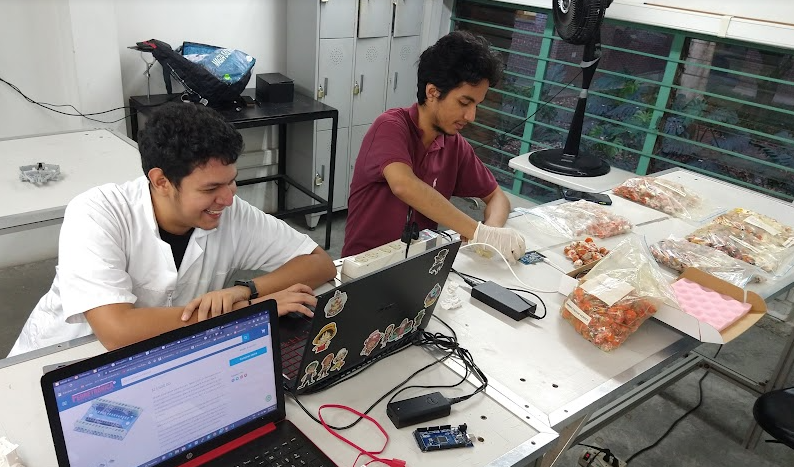

Datos tomados el 24 de febrero de 2023 por Jose Imbachi y Joan Estrada

Desarrollo de este cuaderno: Luis Miguel Aristizábal y Joan Estrada

## Materiales

1. Tarjeta de evaluación FDC2214EVM

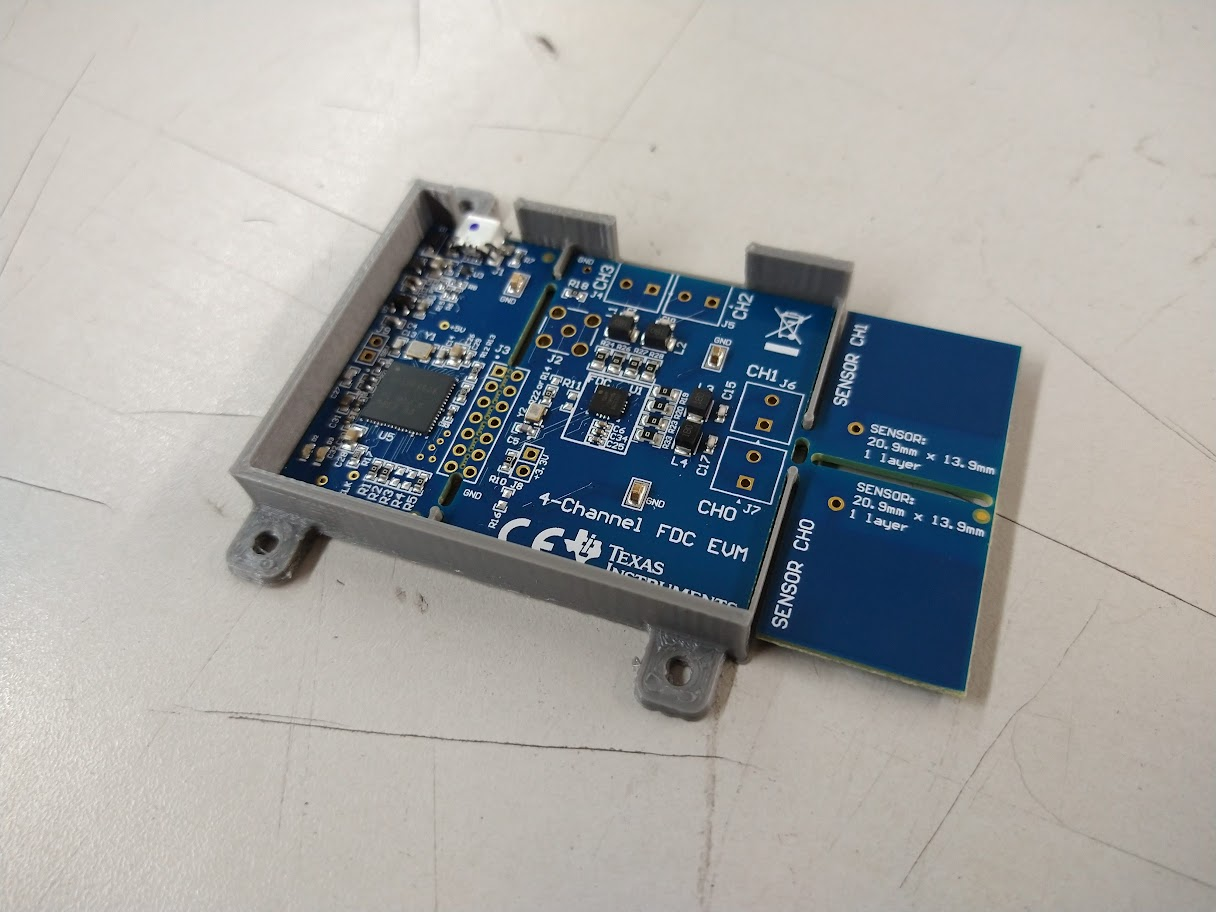

2. Computador con SO Windows y el software de prueba de la eval board
 - Todos los archivos relacionados a la tarjeta de evaluación están en la carpeta "Proyecto Unipalma 2021 - General\Proyecto Unipalma TG\Experimentos\230127_FDC2214EVM_test"

## Consideraciones

Asumir las unidades de las gráficas como:
- Eje y: capacitancia [pF]
- Eje x: muestras

A no ser de que se especifique directamente en la gráfica.

In [45]:
%reset -sf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Prueba de posición

Diccionario con todos los archivos de datos experimentales, la clave es el tipo de fruto evaluado.

In [46]:
df_dic = {'gm': pd.read_csv('230224_GFM.csv'),
          'gsm': pd.read_csv('230224_GFSM.csv'),
          'gv':pd.read_csv('230224_GFV.csv'),
          'hv':pd.read_csv('230224_HFV.csv'),
          'hm':pd.read_csv('230224_HFM.csv'),
          'hsm':pd.read_csv('230224_HFSM.csv')}

Estandarizar base de tiempo:
- columna x como índice
- tiempo inicial 0

Remuestreo
- reducir muestras

In [47]:
samp_factor = 0.5 # tasa a reducir
for key,df in df_dic.items():
    muestras = len(df['DATA0_pF']) * samp_factor
    df_dic[key] = df.set_index('x')
    df_dic[key].index -= df_dic[key].index[0]
    df_dic[key] = df_dic[key][['DATA0_pF']]
    muestreador = np.linspace(df_dic[key].index.min(),df_dic[key].index.max(),int(muestras)).astype(int)
    df_dic[key] = df_dic[key].iloc[muestreador]
    df_dic[key] = df_dic[key].reset_index()

In [48]:
df_dic['gm']

,x,DATA0_pF
0,0,55.296217
1,2,55.295952
2,4,55.296844
3,6,55.297053
4,8,55.296687
...,...,...
10987,21975,55.060042
10988,21977,55.059990
10989,21979,55.059831
10990,21981,55.060406


(54.0, 56.5)

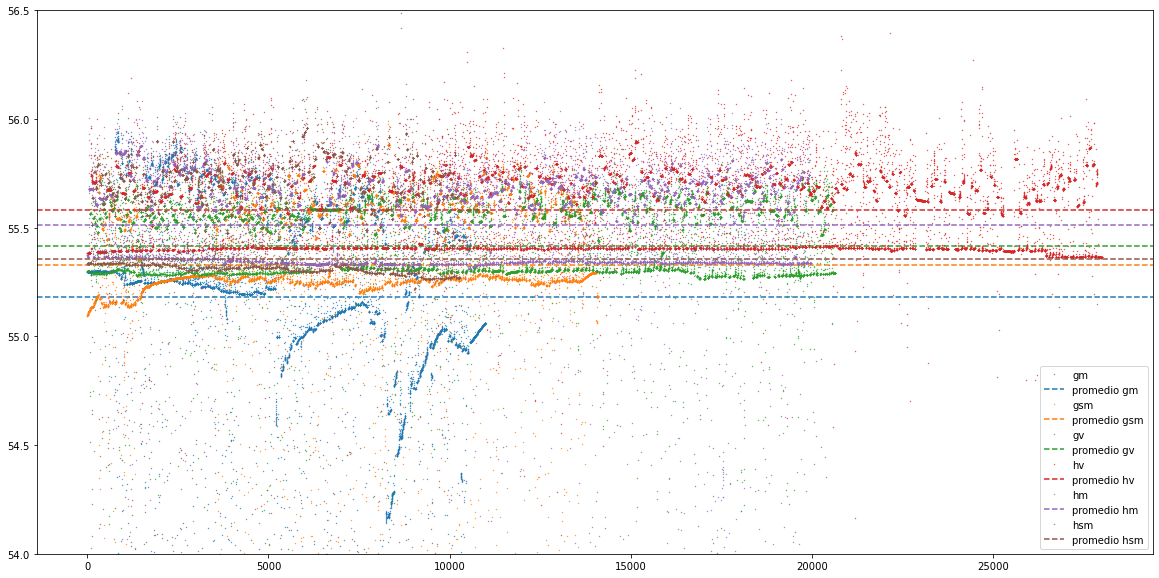

In [49]:
leg = []
plt.rcParams['figure.figsize'] = [20, 10]
for key,df in df_dic.items():
    h = plt.plot(list(df['DATA0_pF']),'.',markersize=0.7)
    leg.append(key)
    ##definición de promedio para visualizar en gráfica
    air = df['DATA0_pF'].mean()
    # air = 55.352502
    plt.axhline(y=air,linestyle='--',color=h[0].get_color())
    leg.append('promedio '+ key)
plt.legend(leg)
plt.ylim([54,56.5])

### eliminar picos paso 1: limitar la señal (usando promedio +- STD)

In [50]:
# pico_inf = 55.5
# pico_sup = 55.9
factor_sup = 2
factor_inf = 0.5

for key,df in df_dic.items():
    stats = df_dic[key].describe()
    promedio = stats.loc['mean']['DATA0_pF']
    #pico superior más alto para que no quite las muestras
    pico_sup = promedio + stats.loc['std']['DATA0_pF']*factor_sup
    #pico inferior más bajo para que quite el nivel 0
    pico_inf = promedio - stats.loc['std']['DATA0_pF']*factor_inf
    query_str = f'DATA0_pF < {pico_sup} and DATA0_pF > {pico_inf}' 
    df_dic[key] = df.query(query_str)
    df_dic[key] = df.reset_index().drop('index',axis=1) # resetea el index, forma no ideal
    
#     print(df)

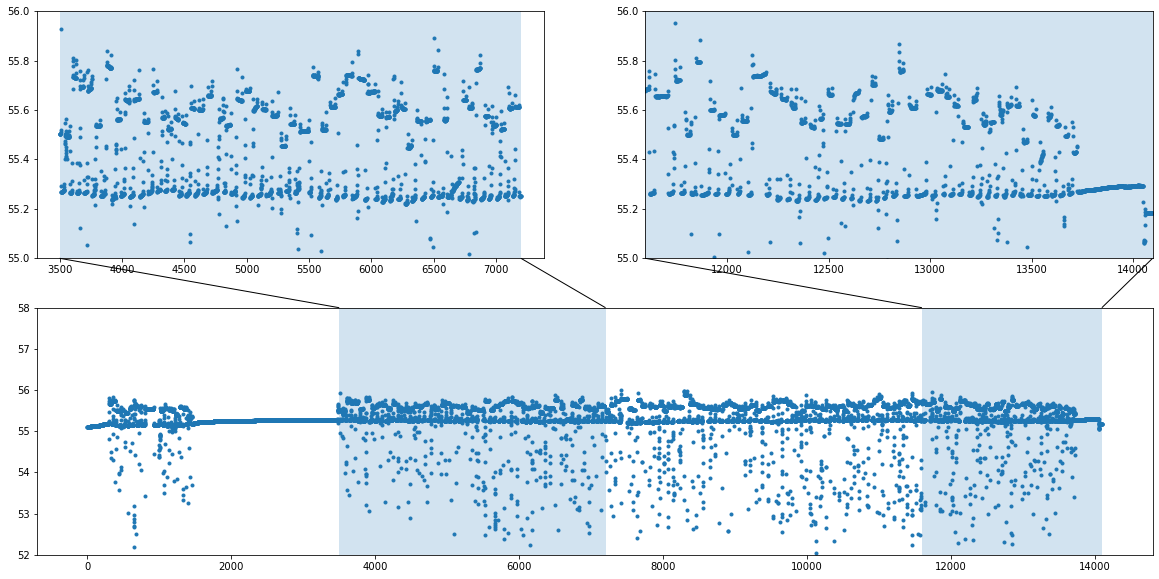

In [51]:
from zoomplot import zoom_effect01,zoom_effect02
#fruto
fruto = 'gsm'

#ventanas a graficar
#ventana inicial
punto_ini = 3500
long_ini = 3700
#ventana final
punto_fin2 = df_dic[fruto].index[-1] #el último valor
long_fin = 2500 #hacia atrás

punto_ini2 = punto_ini+long_ini
punto_fin = punto_fin2-long_fin

completaX = df_dic[fruto].index.tolist()
completaY = df_dic[fruto]['DATA0_pF'].tolist()
inicialX = df_dic[fruto].index[punto_ini:punto_ini2].tolist()
inicialY = df_dic[fruto]['DATA0_pF'].iloc[punto_ini:punto_ini2].tolist()
finalX = df_dic[fruto].index[punto_fin:punto_fin2].tolist()
finalY = df_dic[fruto]['DATA0_pF'].iloc[punto_fin:punto_fin2].tolist()

axs = plt.figure().subplot_mosaic([
    ["zoom1", "zoom2"],
    ["main", "main"],
])

axs['main'].plot(completaX,completaY,'.')
axs['zoom1'].plot(inicialX,inicialY,'.')
axs['zoom2'].plot(finalX,finalY,'.')

axs["main"].set(ylim=(52, 58))
axs["zoom1"].set(ylim=(55, 56))
axs["zoom2"].set(ylim=(55, 56))
zoom_effect01(axs["zoom1"], axs["main"], punto_ini, punto_ini2)
axs["zoom2"].set(xlim=(punto_fin,punto_fin2 ))
zoom_effect02(axs["zoom2"], axs["main"])

plt.show()

Después de revisar los datos, variedad por variedad, se observa:

- mediciones de híbridos son parejas y homogéneas, con una medición de vacío estable.
- mediciones de guineensis sobremaduro tienen variación de medición de vacío.
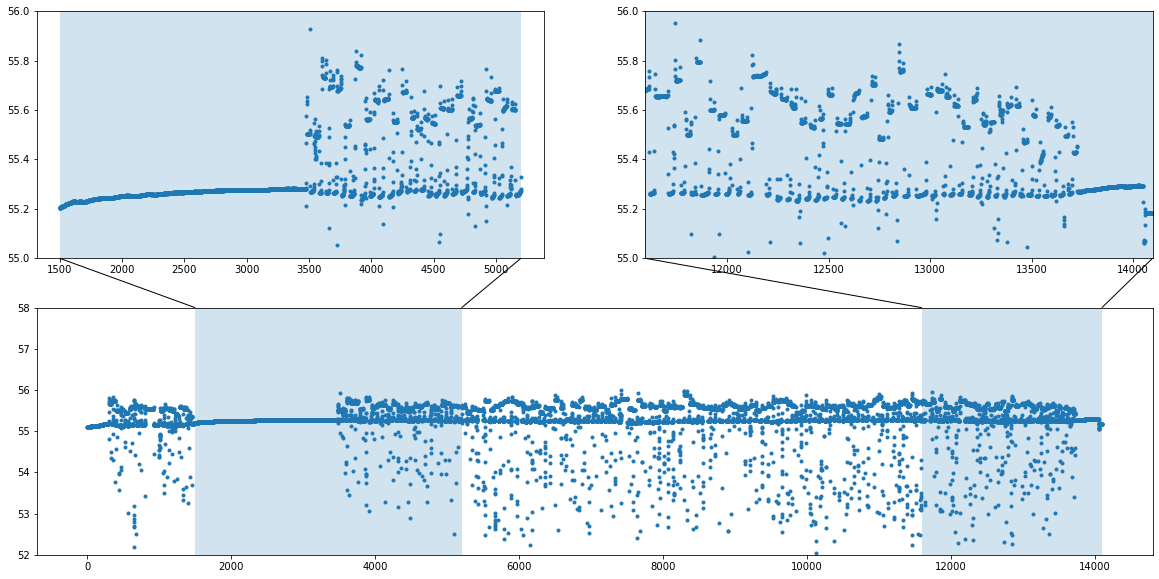
- mediciones de guineensis maduro tienen variación sustancial de medición de vacío.
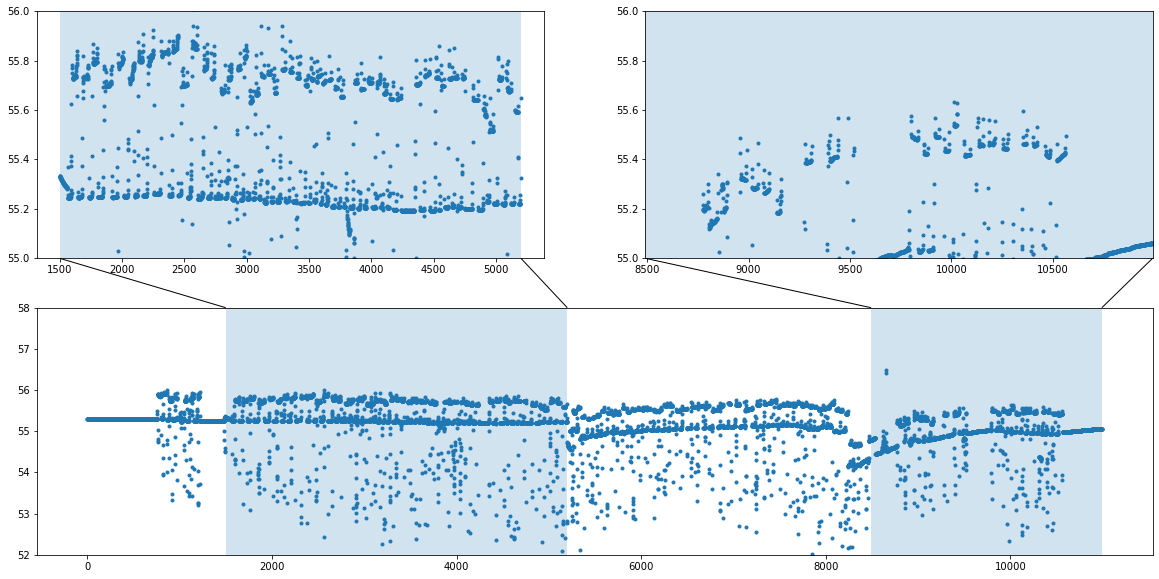
En los dos últimos hay que reducir la ventana de datos mientras se procesan.

<span class="mark">REVISAR CÓMO SE HIZO LA MEDICIÓN DE ESTOS ÚLTIMOS.</span>

In [52]:
# punto_ini_gm = 1500
# long_ini_gm = 3700
# punto_ini2_gm = punto_ini_gm+long_ini_gm

# punto_ini_gsm = 3500



# df_dic['gm'] = df_dic['gm'].iloc[punto_ini_gm:punto_ini2_gm]
# df_dic['gsm'] = df_dic['gsm'].iloc[punto_ini_gsm:]


### alt. 3: Gradiente para identificar las mayores zonas de cambio

Podemos aplicar el filtro de promedio +- SD, PERO con los resultados del gradiente, deberíamos poder hacer una distinción mucho más clara.

Para esto debemos agregar el gradiente a cada df.

In [53]:
for key,df in df_dic.items():
    df_dic[key]['gradient'] = np.gradient(df_dic[key]['DATA0_pF'])

In [54]:
df_dic['gm']

,x,DATA0_pF,gradient
0,0,55.296217,-0.000265
1,2,55.295952,0.000314
2,4,55.296844,0.000550
3,6,55.297053,-0.000078
4,8,55.296687,0.000132
...,...,...,...
10987,21975,55.060042,-0.000441
10988,21977,55.059990,-0.000105
10989,21979,55.059831,0.000208
10990,21981,55.060406,0.000000


Como los resultados del filtrado son progresivos, es decir, si se aplican filtrados sucesivos, va mejorando el resultado.

Para ver el resultado, vamos a dejar rastro de cada filtrado para compararlos (esto no es necesario cuando ya se tenga refinado el método)

In [55]:
# df_dic_2 = {}
df_dic_list = [df_dic.copy()] #sin copy se modifica el original
factor = 1
pasadas = 3
for i in range(pasadas):
    df_dic_2 = df_dic_list[i].copy()
    for key,df in df_dic_2.items():
        df_mean = df_dic_2[key]['gradient'].mean()
        df_std = df_dic_2[key]['gradient'].std()
        #pico superior más alto para que no quite las muestras
        pico_sup = df_mean + df_std*factor
        #pico inferior más bajo para que quite el nivel 0
        pico_inf = df_mean - df_std*factor
        query_str = f'gradient < {pico_sup} and gradient > {pico_inf}' 
        df_dic_2[key] = df_dic_2[key].query(query_str)
    df_dic_list.append(df_dic_2)
    i+=1

In [56]:
df_dic_list

[{'gm':            x   DATA0_pF  gradient
  0          0  55.296217 -0.000265
  1          2  55.295952  0.000314
  2          4  55.296844  0.000550
  3          6  55.297053 -0.000078
  4          8  55.296687  0.000132
  ...      ...        ...       ...
  10987  21975  55.060042 -0.000441
  10988  21977  55.059990 -0.000105
  10989  21979  55.059831  0.000208
  10990  21981  55.060406  0.000000
  10991  21984  55.059831 -0.000575
  
  [10992 rows x 3 columns],
  'gsm':            x   DATA0_pF  gradient
  0          0  55.095065  0.002027
  1          2  55.097092  0.000362
  2          4  55.095789 -0.000703
  3          6  55.095685  0.000546
  4          8  55.096881  0.000390
  ...      ...        ...       ...
  14092  28185  55.184111  0.000000
  14093  28187  55.183541 -0.000337
  14094  28189  55.183437 -0.000026
  14095  28191  55.183489 -0.000080
  14096  28194  55.183277 -0.000212
  
  [14097 rows x 3 columns],
  'gv':            x   DATA0_pF  gradient
  0          0  55.

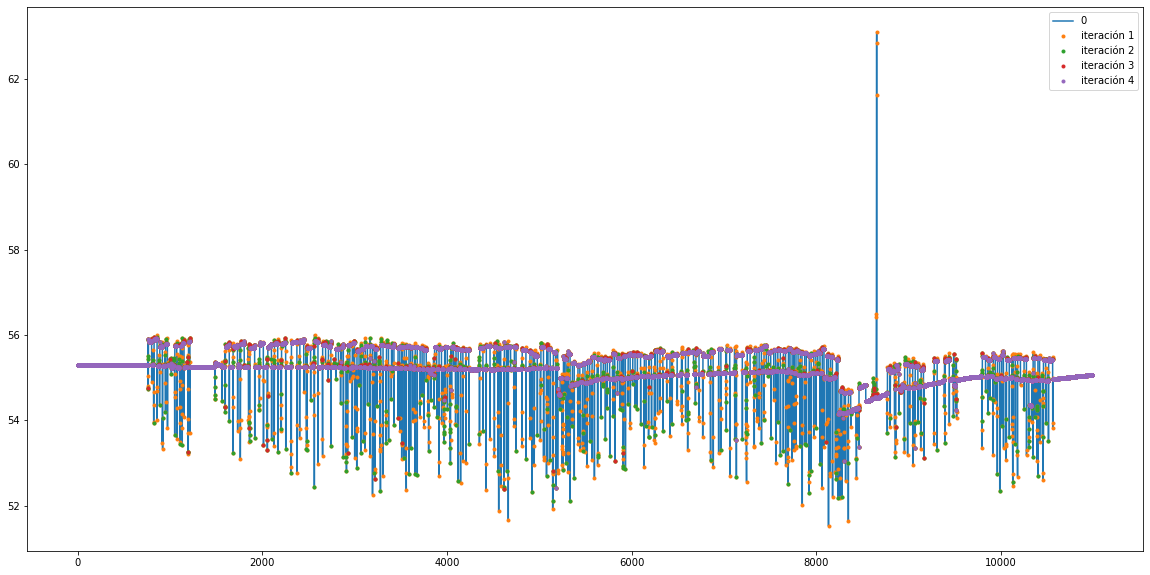

In [57]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot(df_dic['gm'].index,list(df_dic['gm']['DATA0_pF']),'-')
intento = 0
leg = [str(intento)]
for dic in df_dic_list:
    plt.plot(dic['gm'].index,list(dic['gm']['DATA0_pF']),'.')
    intento += 1
    leg.append('iteración '+str(intento))
plt.legend(leg)

## Selección del valor por máquinas de estado

Tomando la versión de los datos más filtrada, podría 

tomamos la última iteración del filtrado (lista\[-1\])

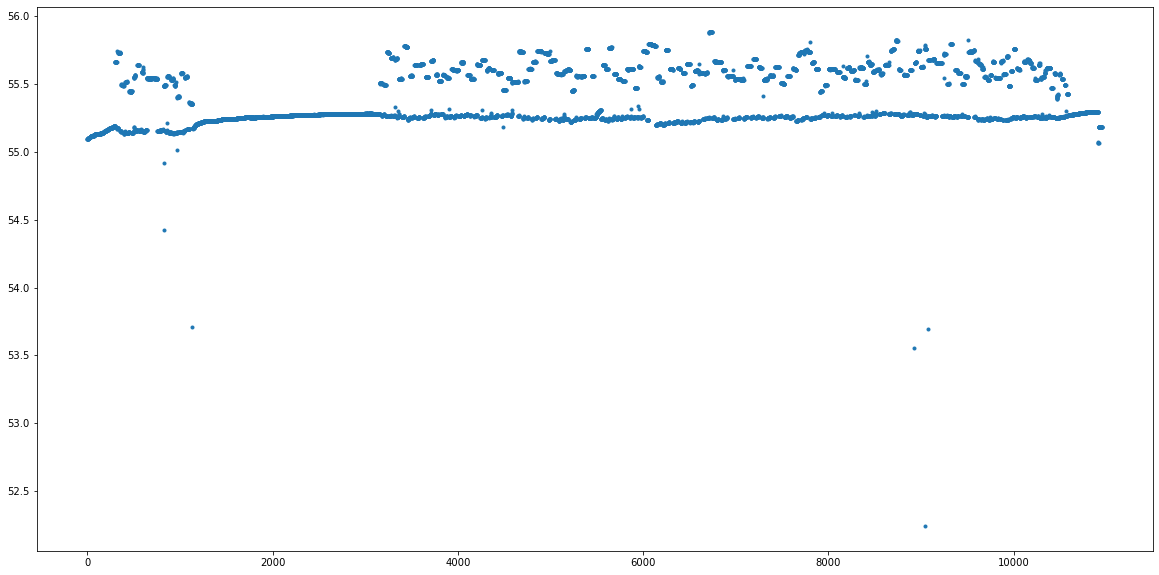

In [58]:
# for key,df in df_dic_list[-1].items():
h = plt.plot(list(df_dic_list[-1]['gsm']['DATA0_pF']),'.')
# h[0].get_color()

(55.0, 56.0)

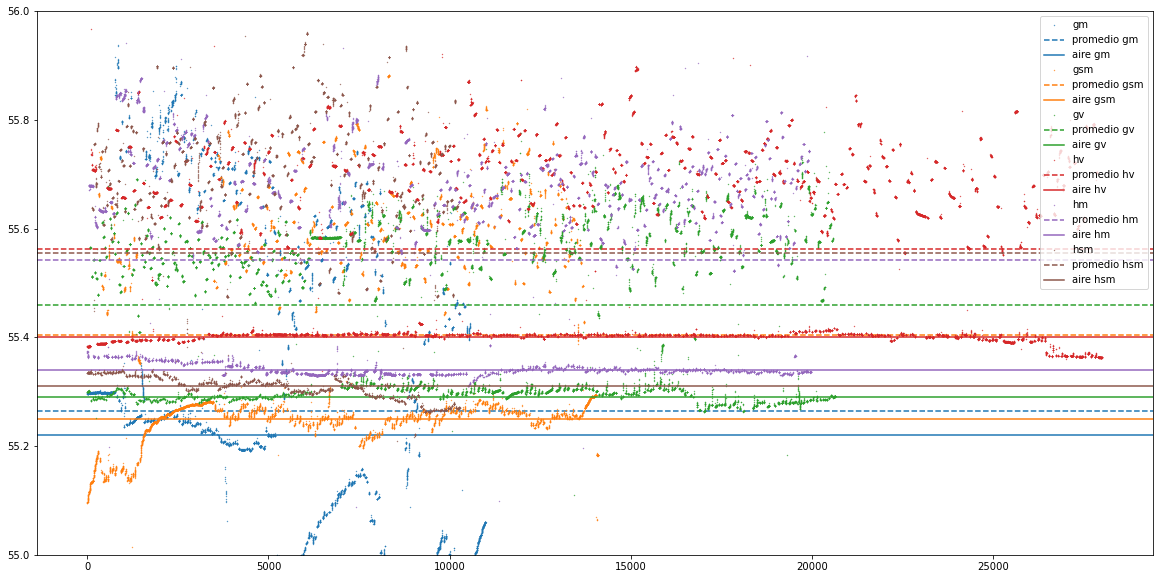

In [59]:
# a mano se toman estos valores
dict_air = {'gv':55.29,
            'gm':55.22,
            'gsm':55.25,
            'hv':55.4,
            'hm':55.34,
            'hsm':55.31}

df_dic_proc = df_dic_list[-1].copy()
leg = []
for key,df in df_dic_proc.items():
    air = df['DATA0_pF'].mean()
    h = plt.plot(df['DATA0_pF'],'.',markersize=0.7)
    leg.append(key)
    ##Corroboramos que se haya descartado la medida al aire
    plt.axhline(y=air,linestyle='--',color=h[0].get_color())
    leg.append('promedio '+ key)
    plt.axhline(y=dict_air[key],linestyle='-',color=h[0].get_color())
    leg.append('aire '+ key)
plt.legend(leg)
plt.ylim([55,56])




<span class="mark">Se pueden notar las diferencias en los valores en vacío. Este es un punto importante a resolver</span>

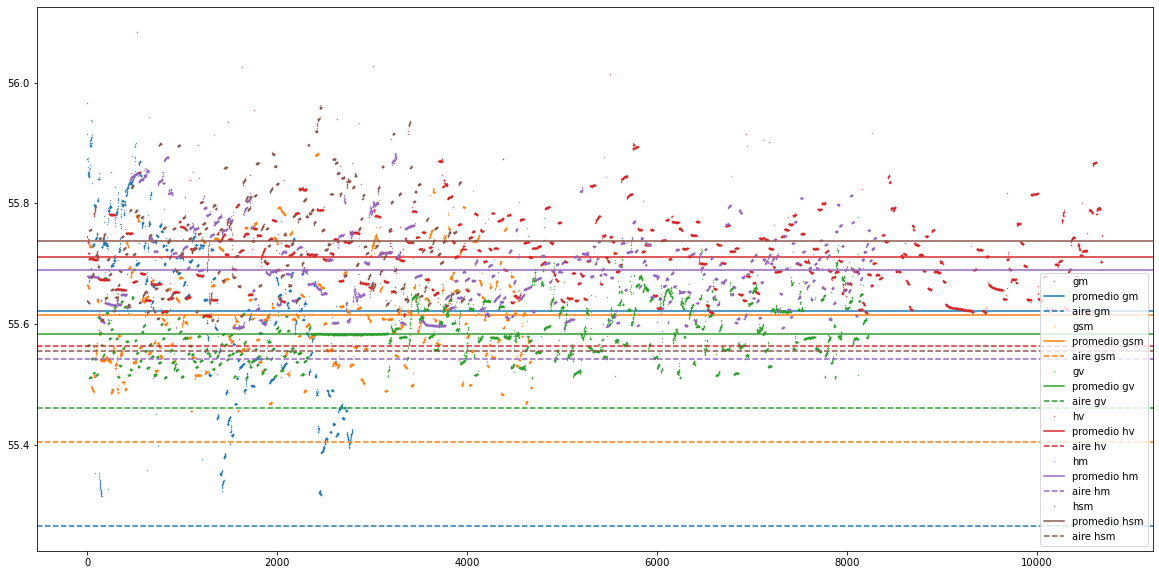

In [60]:
dict_clean = {}
leg = []
for key,df in df_dic_proc.items():
    Value_list = df['DATA0_pF']
    clean_list=[]
    air = df['DATA0_pF'].mean()
    for clean in Value_list:
        if clean > air+0.05:
            clean_list.append(clean)
    dict_clean[key] = clean_list
    h = plt.plot(clean_list,'.',markersize=0.7)
    leg.append(key)
    prom = np.mean(clean_list)
    plt.axhline(y=prom,linestyle='-',color=h[0].get_color())
    leg.append('promedio '+ key)
    plt.axhline(y=air,linestyle='--',color=h[0].get_color())
    leg.append('aire '+ key)
plt.legend(leg)



### Algoritmo

Para cada valor de los datos limpios:
- comparar con la media anterior +- ventana
  - si está en la ventana: 
    - guarde el valor en vector
    - aumente el contador de muestras
  - sino:
    - media anterior  = media
    - calcular media de lo que acumuló en vector
    - guardar en matrix
    - reiniciar vector y muestras
    
### Modificaciones:

Se hace con enumerate para guardar los índices, con esto verificamos que si quede la marca en el gráfico.

Se guardan las muestras para eliminar mediciones muy cortas (< ```min_samples``` muestras)

Hay que forzar un cambio al final para que no bote el último dato, puede ser un valor en el minimo del dataset

### Mejoras Pendientes:

Con este método no se distinguen bien las mediciones de frutos contíguos que arrojen valores muy cercanos entre sí. Para esto considerar la medición de aire previa a la medición de cada fruto.

In [61]:
##Creamos gráfico de dispersión y sacamos la media de la medición
min_samples = 15
window = 0.005
dict_mediciones = {}

for key,clean_list in dict_clean.items():
    cleanMediaAnt = 0
    cleanMedia = 0
    CleanMatrix = np.array([[0,0,0]])
    CleanVector = []
    CleanVectorMedia = 0
    samples = 0
    clean_list.append(min(clean_list))

    for i,cleanMedia in enumerate(clean_list):
        if (cleanMediaAnt-window) < cleanMedia and cleanMedia < (cleanMediaAnt+window):
            CleanVector.append(cleanMedia)
            samples += 1
        else:
            cleanMediaAnt = cleanMedia
            CleanVectorMedia=np.mean(CleanVector)
            if ~np.isnan(CleanVectorMedia) and samples > min_samples:
                CleanMatrix = np.vstack([CleanMatrix,[i,CleanVectorMedia,samples]])
            CleanVector=[]
            samples = 0
    CleanMatrix = CleanMatrix[1:,...] # quitar la fila 1, no es ideal pero sirve.
    dfClean = pd.DataFrame(CleanMatrix,columns=['i_muestra','valor_pF','long_muestra'])
    dict_mediciones[key] = dfClean
print("END")
dict_mediciones

END


C:\Users\LMAG\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\LMAG\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'gm':     i_muestra   valor_pF  long_muestra
 0        72.0  55.730760          21.0
 1       203.0  55.733217          22.0
 2       449.0  55.832354          19.0
 3       466.0  55.833994          16.0
 4       499.0  55.844885          17.0
 5       542.0  55.699669          31.0
 6       726.0  55.737086          16.0
 7       746.0  55.745761          18.0
 8       779.0  55.763636          18.0
 9       862.0  55.736508          16.0
 10      899.0  55.723079          17.0
 11      916.0  55.688573          16.0
 12      935.0  55.652727          18.0
 13      954.0  55.710624          18.0
 14      976.0  55.684481          21.0
 15     1001.0  55.711033          24.0
 16     1048.0  55.644484          17.0
 17     1073.0  55.647641          23.0
 18     1101.0  55.704030          27.0
 19     1133.0  55.743991          20.0
 20     1155.0  55.731225          16.0
 21     1172.0  55.697790          16.0
 22     1191.0  55.726075          17.0
 23     1211.0  55.730532         

array([55.56488373, 55.51190361, 55.54298834, 55.54188825, 55.58517606,
       55.56513582, 55.54835511, 55.67653594, 55.61856592, 55.57656932,
       55.59170956, 55.55367826, 55.62944516, 55.51231815, 55.63750322,
       55.62889447, 55.57133473, 55.51562524, 55.64401608, 55.55209622,
       55.52968262, 55.53922869, 55.58726132, 55.59791167, 55.55559929,
       55.52780991, 55.56617025, 55.54647373, 55.51607669, 55.54577656,
       55.53642289, 55.60030124, 55.57644855, 55.5120926 , 55.62077632,
       55.59165425, 55.55662983, 55.53693479, 55.52429429, 55.58769187,
       55.51323628, 55.57712126, 55.55122575, 55.56414989, 55.54978544,
       55.53826053, 55.52915635, 55.58013964, 55.53975815, 55.61231825,
       55.55698456, 55.55176871, 55.5376965 , 55.5256535 , 55.55469204,
       55.54702377, 55.5338829 , 55.56693992, 55.58378435, 55.56571895,
       55.54903693, 55.58208095, 55.55140485, 55.51345108, 55.55541627,
       55.59349711, 55.55047086, 55.61692393, 55.56964567, 55.51

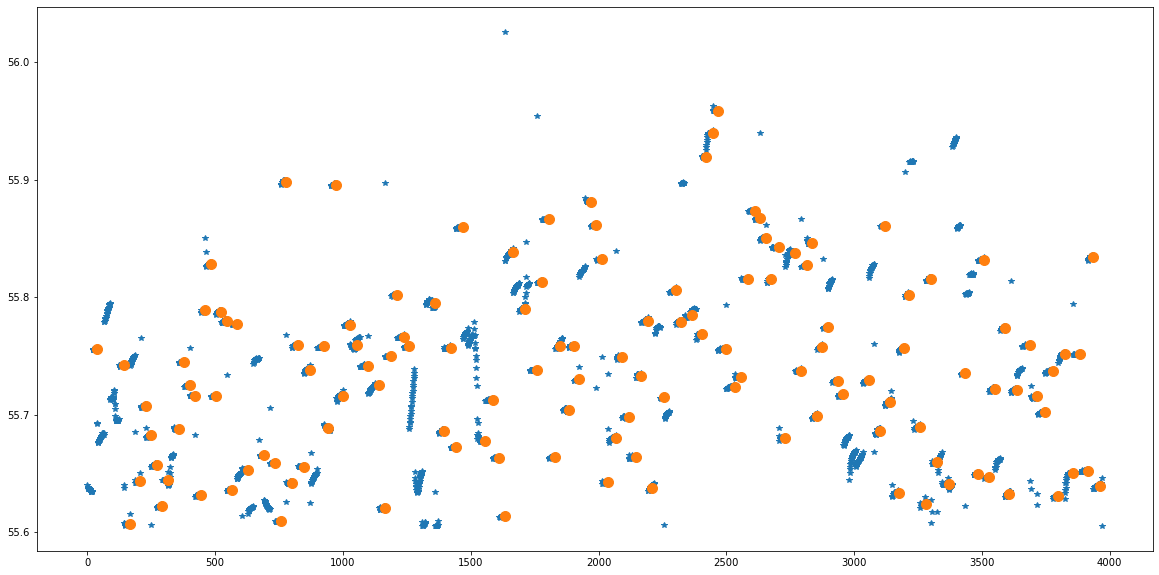

In [62]:
plt.plot(clean_list,'*')
plt.plot(CleanMatrix[:,0],CleanMatrix[:,1],'o',markersize = 10)
dict_mediciones['gv'].iloc[:,[1]].values.flatten()

## Gráfica box-whiskers

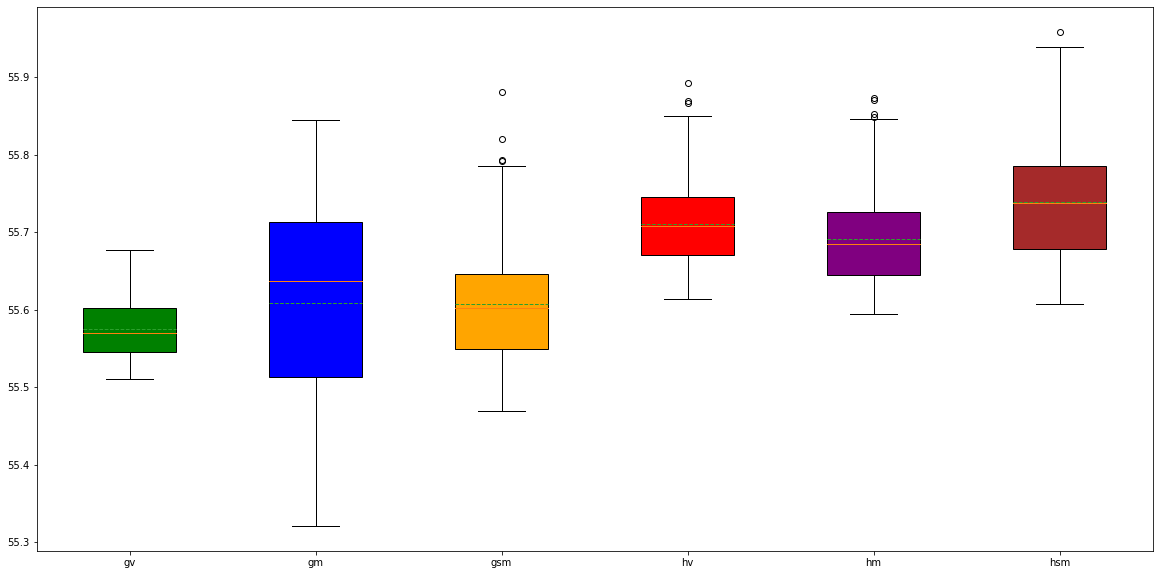

([array([55.56488373, 55.51190361, 55.54298834, 55.54188825, 55.58517606,
         55.56513582, 55.54835511, 55.67653594, 55.61856592, 55.57656932,
         55.59170956, 55.55367826, 55.62944516, 55.51231815, 55.63750322,
         55.62889447, 55.57133473, 55.51562524, 55.64401608, 55.55209622,
         55.52968262, 55.53922869, 55.58726132, 55.59791167, 55.55559929,
         55.52780991, 55.56617025, 55.54647373, 55.51607669, 55.54577656,
         55.53642289, 55.60030124, 55.57644855, 55.5120926 , 55.62077632,
         55.59165425, 55.55662983, 55.53693479, 55.52429429, 55.58769187,
         55.51323628, 55.57712126, 55.55122575, 55.56414989, 55.54978544,
         55.53826053, 55.52915635, 55.58013964, 55.53975815, 55.61231825,
         55.55698456, 55.55176871, 55.5376965 , 55.5256535 , 55.55469204,
         55.54702377, 55.5338829 , 55.56693992, 55.58378435, 55.56571895,
         55.54903693, 55.58208095, 55.55140485, 55.51345108, 55.55541627,
         55.59349711, 55.55047086, 55.

In [63]:
valores = []
valores_aire = []
leg = ['gv','gm','gsm','hv','hm','hsm']
for key in leg:
    valores.append(dict_mediciones[key].iloc[:,[1]].values.flatten())
    valores_aire.append(dict_air[key])

bplot = plt.boxplot(valores,
                    showmeans=True,
                    meanline=True,
                    patch_artist=True,
                    labels=leg)

colors = ['green', 'blue', 'orange', 'red','purple','brown']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

valores,valores_aire

<ipython-input-64-080d09e1db9c>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bplot = plt.boxplot(valores-np.array(valores_aire),


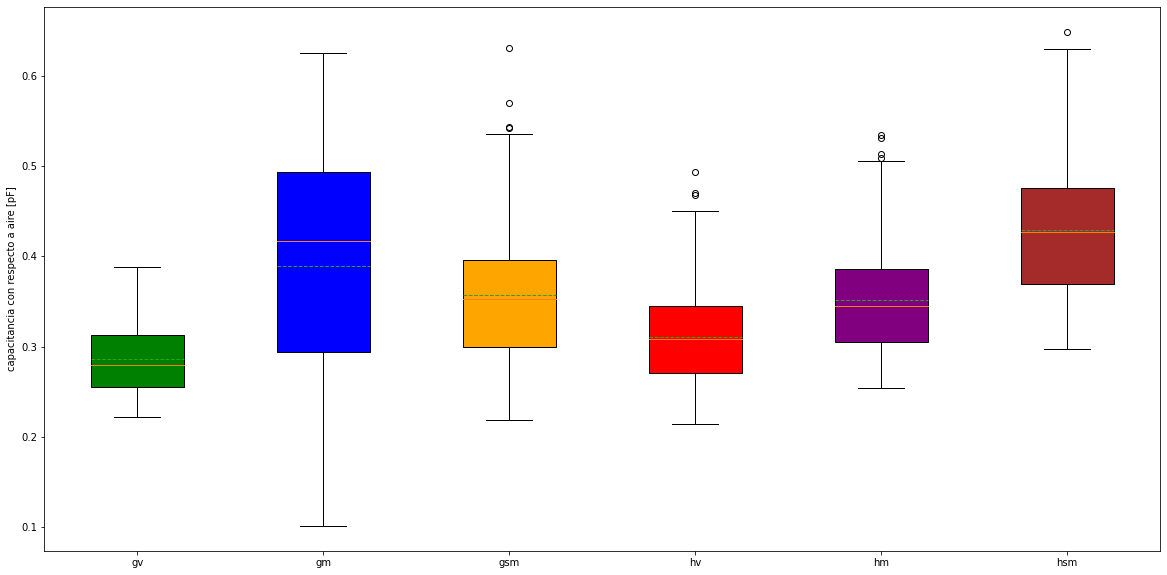

In [64]:
# fig, axs = plt.subplots(nrows=1, ncols=2)

# generate some random test data

# plot violin plot:
# bplot = plt.boxplot([dict_mediciones['gv'][:,1]-dict_air['gv'],
#                     dict_mediciones['gm'][:,1]-dict_air['gm'],
#                     dict_mediciones['gsm'][:,1]-dict_air['gsm'],
#                     dict_mediciones['hv'][:,1]-dict_air['hv'],
#                     dict_mediciones['hm'][:,1]-dict_air['hm'],
#                     dict_mediciones['hsm'][:,1]-dict_air['hsm']],
#                     showmeans=True,
#                     meanline=True,
#                     patch_artist=True,
#                     labels=['gv','gm','gsm','hv','hm','hsm'])

bplot = plt.boxplot(valores-np.array(valores_aire),
                    showmeans=True,
                    meanline=True,
                    patch_artist=True,
                    labels=leg)

colors = ['green', 'blue', 'orange', 'red','purple','brown']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.ylabel('capacitancia con respecto a aire [pF]')
plt.show()

### Exportar datos

Exportación de datos a xlsx para visualización por hojas

In [65]:
# from openpyxl import load_workbook

# with open('dict_mediciones.xlsx','w') as f:
#     pass

# book = load_workbook('dict_mediciones.xlsx')
writer = pd.ExcelWriter('dict_mediciones.xlsx', engine='openpyxl') 

for key,df in dict_mediciones.items():
    df.to_excel(writer, sheet_name=key)
    
# El promedio de mediciones en aire se guarda en otra hoja.
pd.DataFrame(dict_air.items()).to_excel(writer,sheet_name='med_aire')

writer.save()

### Histograma

In [67]:

# for key,m in dict_mediciones.items():
#     counts, bins = np.histogram(m[:,1],bins=30)
# #     plt.stairs(counts, bins)
    

## Pasos siguientes

1. Mejorar el método de medición

Esto implica explorar un primer prototipo de medición con hardware propio. Para esto vamos a listar los ejemplos que pueden ser de utilidad:
- [Script de python basado en otro sensor](https://e2e.ti.com/support/sensors-group/sensors/f/sensors-forum/618997/fdc2214evm-python-script-for-fdc2214evm)
- 